# Import Libraries

In [1]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder

import tweepy

from warnings import filterwarnings
filterwarnings ('ignore')

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Twitter API
<br>

##### For more informations about Twitter API you can use this link.
https://developer.twitter.com/en/docs/twitter-api

In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tweepy
import pandas as pd

consumer_key = 'WmqDx2vHvVTg6ZpqCVomx2qDt'
consumer_secret = '2HMXCay6lla9mRyG2A8Ion2yq0P1TsB0FmzWSUQgKRtby6dEnU'
access_token = '16065195-lcOE7dsySGMD0EETkhDM3ZnJ3iK9ZjYmcp1fzHIXM'
access_token_secret = 'vYp7EGo9JwPLHGbxK4V8rZoZ3l1nR6RKVl6ZLZRKBSLQg'

In [5]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [6]:
# We get the tweets with hastag "BTC", in english.

tweets = api.search_tweets(q = "F1", lang = "en", count = 100)

In [7]:
def hashtag_df(tweets):
    import pandas as pd
    id_list = [tweet.id for tweet in tweets]
    dataframe = pd.DataFrame(id_list, columns = ["id"])
    
    dataframe["user"] = [tweet.author.screen_name for tweet in tweets]
    dataframe["text"] = [tweet.text for tweet in tweets]
    dataframe["hashtags"] = [tweet.entities.get("hashtags") for tweet in tweets]
    
    return dataframe

In [8]:
df = hashtag_df(tweets)
df = df.drop_duplicates("user", keep = "first")
df.drop("id", axis=1, inplace=True)
df.index = df["user"]
df.drop("user", axis=1, inplace=True)

# Let's see our dataset...

df.head()

,text,hashtags
user,,
TwiknightRei,@MAiJiNTHEARTIST Off-chain... smart contract.....,[]
Jhonwic65,$XRP &amp; $sun buy the dip 😘🚀\nhttps://t.co/b...,[]
chanel22111,nft \n DOG \n shib \n btc \n USDT \n Quincy M...,"[{'text': '代收', 'indices': [113, 116]}, {'text..."
aunwichada,"RT @SUI_C0MMUNITY: $2,500,000 - USDT #Giveaway...","[{'text': 'Giveaway', 'indices': [37, 46]}]"
aorabi85,#CRYPTO is shooting up! Use https://t.co/LRb24...,"[{'text': 'CRYPTO', 'indices': [0, 7]}]"


<hr style="height:2px;border-width:0;color:white;background-color:green">

# Dataset Cleaning

In [9]:
# Texts will be lower
df["text"] = df["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

# We get rid of the punctuations
df["text"] = df["text"].str.replace('[^\w\s]', '')

# And also numbers we don't need it in text.
df["text"] = df["text"].str.replace('\d', '')

# Stopwords! It is a library with some adverbs, plural suffix etc. that they are not important for the analysis
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

# We reach to the root of the word with lemmatize.
from textblob import Word
nltk.download('wordnet')
df["text"] = df["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Retweets... We don't need them.
df["text"] = df["text"].str.replace('rt','')

# reset index
df = df.reset_index()
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,user,text,hashtags
0,TwiknightRei,maijintheaist offchain sma contract using ai e...,[]
1,Jhonwic65,xrp amp sun buy dip httpstcobptwwojr btc shib ...,[]
2,chanel22111,nft dog shib btc usdt quincy moulton hannah ja...,"[{'text': '代收', 'indices': [113, 116]}, {'text..."
3,aunwichada,sui_cmmunity usdt giveaway paicipant retweet ...,"[{'text': 'Giveaway', 'indices': [37, 46]}]"
4,aorabi85,crypto shooting use httpstcolrbfeymt find coin...,"[{'text': 'CRYPTO', 'indices': [0, 7]}]"


<hr style="height:2px;border-width:0;color:white;background-color:green">

# Sentiment Analysis

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

# The range of polarity is from -1 to 1(negative to positive) and will tell us if the text contains positive or negative feedback.
df["polarity_score"] = df["text"].apply(lambda x: vader.polarity_scores(x)["compound"])

# So we labeling the scores as positive or negative.
df["sentiment_label"] = df["text"].apply(lambda x: "pos" if vader.polarity_scores(x)["compound"] > df["polarity_score"].median() else "neg")

# That part is just for encoding.
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

df.head()

,user,text,hashtags,polarity_score,sentiment_label
0,TwiknightRei,maijintheaist offchain sma contract using ai e...,[],0.0000,0
1,Jhonwic65,xrp amp sun buy dip httpstcobptwwojr btc shib ...,[],0.0000,0
2,chanel22111,nft dog shib btc usdt quincy moulton hannah ja...,"[{'text': '代收', 'indices': [113, 116]}, {'text...",0.5574,1
3,aunwichada,sui_cmmunity usdt giveaway paicipant retweet ...,"[{'text': 'Giveaway', 'indices': [37, 46]}]",0.1027,0
4,aorabi85,crypto shooting use httpstcolrbfeymt find coin...,"[{'text': 'CRYPTO', 'indices': [0, 7]}]",0.0000,0


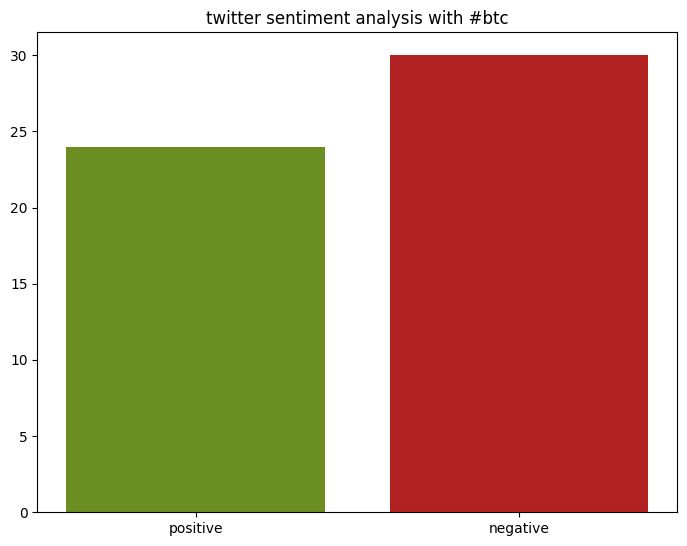

In [12]:
# Let's check the positive and negative labels...

pos = df[df["sentiment_label"]==1]["sentiment_label"].count()
neg = df[df["sentiment_label"]==0]["sentiment_label"].count()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sent = ['positive', 'negative']
count = [pos, neg]
ax.bar(sent,count, color=["#6B8E23", '#B22222'])
ax.set_title("twitter sentiment analysis with #btc")
plt.show()

<hr style="height:2px;border-width:0;color:white;background-color:green">

# TF-IDF (Term Frequency - Inverse Document Frequency)

#### *TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency.<br>This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.*

In [13]:
# We describe our feature and target.
y = df["sentiment_label"]  #target
X = df["text"]

# CountVectorizer returns unigrams or single words.
# If we increase the ngram_range, the vocabulary is expanded from single words to short phrases. 

# word vectorize (checking one word)
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

# n_gram vectorize (checking double words - phrases)
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

<hr style="height:2px;border-width:0;color:white;background-color:green">

# Sentiment Modelling

In [14]:
# Logistic Regression

# word
log_model_word = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model_word,
               X_tf_idf_word,
               y,
               scoring="accuracy",
               cv=5).mean()

0.7381818181818182

In [15]:
# Logistic Regression

# ngram
log_model_ngram = LogisticRegression().fit(X_tf_idf_word, y)

cross_val_score(log_model_ngram,
               X_tf_idf_ngram,
               y,
               scoring="accuracy",
               cv=5).mean()

0.7563636363636363

In [16]:
# Let's pick up a random tweet.

random_tweet = pd.Series(df["text"].sample(1).values)
random_tweet[0]

'crypto shooting use httpstcolrbfeymt find coin moving track crypto high buyer httpstcobzexelq'

In [17]:
# Example
# random tweet analysis

random_tweet = TfidfVectorizer().fit(X).transform(random_tweet)

# with Logistic Regression by word vectorize we found better score that's why we use for a predict log_model_word..

log_model_word.predict(random_tweet)

array([0])